<a href="https://colab.research.google.com/github/pramodmisra/handson-ml/blob/master/RandomForest_ecommerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing an ecommerce customer behavioral dataset from kaggle

In [0]:
#importing important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as dates
from datetime import datetime

In [15]:
!pip install kaggle

In [16]:
#creating a directory
!ls

kaggle.json  sample_data


In [17]:
!mkdir .kaggle

mkdir: cannot create directory ‘.kaggle’: File exists


In [18]:
!ls

kaggle.json  sample_data


In [0]:
#using credentials to open kaggle dataset
import json
token = {"username":"pramodmisra2020","key":"9db04db1ececf8ccac1cf1ff02611f71"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [21]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [23]:
! kaggle datasets list

ref                                                         title                                                size  lastUpdated          downloadCount  
----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
allen-institute-for-ai/CORD-19-research-challenge           COVID-19 Open Research Dataset Challenge (CORD-19)    3GB  2020-05-20 17:23:43          69301  
roche-data-science-coalition/uncover                        UNCOVER COVID-19 Challenge                          142MB  2020-04-29 22:47:23           9819  
timxia/enriched-global-mobility-data-apple-google           Enriched Global Mobility Data (Apple + Google)        3MB  2020-05-04 06:52:35            456  
gyejr95/tft-match-data                                      TFT(League Of Legends) - High Elo Ranked Games       13MB  2020-05-10 07:08:59            297  
susuwatari/epa-vehicle-dataset-19802021                     EPA 

In [24]:
#downloading the zipped dataset folder on cloud
!kaggle datasets download -d mkechinov/ecommerce-behavior-data-from-multi-category-store -p /content

100% 4.28G/4.29G [00:55<00:00, 72.2MB/s]
100% 4.29G/4.29G [00:55<00:00, 83.0MB/s]


In [25]:
#unzipping the folder
!unzip \*.zip

Archive:  ecommerce-behavior-data-from-multi-category-store.zip
  inflating: 2019-Nov.csv            
  inflating: 2019-Oct.csv            


In [26]:
#reading the dataframe
import pandas as pd
df = pd.read_csv('2019-Oct.csv')
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


In [27]:
#columns in dataframe
df.columns

Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session'],
      dtype='object')

In [28]:
#unique visitors
visitor = df['user_id'].nunique()
print ("visitors: {}".format(visitor))

visitors: 3022290


In [29]:
#number of null values
df.isnull().sum()


event_time              0
event_type              0
product_id              0
category_id             0
category_code    13515609
brand             6117080
price                   0
user_id                 0
user_session            2
dtype: int64

In [30]:
#unique values in all columns of given dataframe
for i in df.columns:
    print(i+"  ",str(len(df[i].unique())))


event_time   2621538
event_type   3
product_id   166794
category_id   624
category_code   127
brand   3445
price   65298
user_id   3022290
user_session   9244422


In [31]:
#datatypes of columns
df.dtypes

event_time        object
event_type        object
product_id         int64
category_id        int64
category_code     object
brand             object
price            float64
user_id            int64
user_session      object
dtype: object

In [32]:
#value counts of brand
df['brand'].value_counts()[:10]

samsung    5282775
apple      4122554
xiaomi     3083763
huawei     1111205
lucente     655861
lg          562404
bosch       557090
oppo        482887
sony        456644
acer        428153
Name: brand, dtype: int64

In [33]:
#value counts of category_code
df['category_code'].value_counts()[:10]

electronics.smartphone              11507231
electronics.clocks                   1311033
computers.notebook                   1137623
electronics.video.tv                 1113750
electronics.audio.headphone          1100188
appliances.kitchen.refrigerators      887755
appliances.kitchen.washer             869404
appliances.environment.vacuum         801670
apparel.shoes                         763901
auto.accessories.player               470208
Name: category_code, dtype: int64

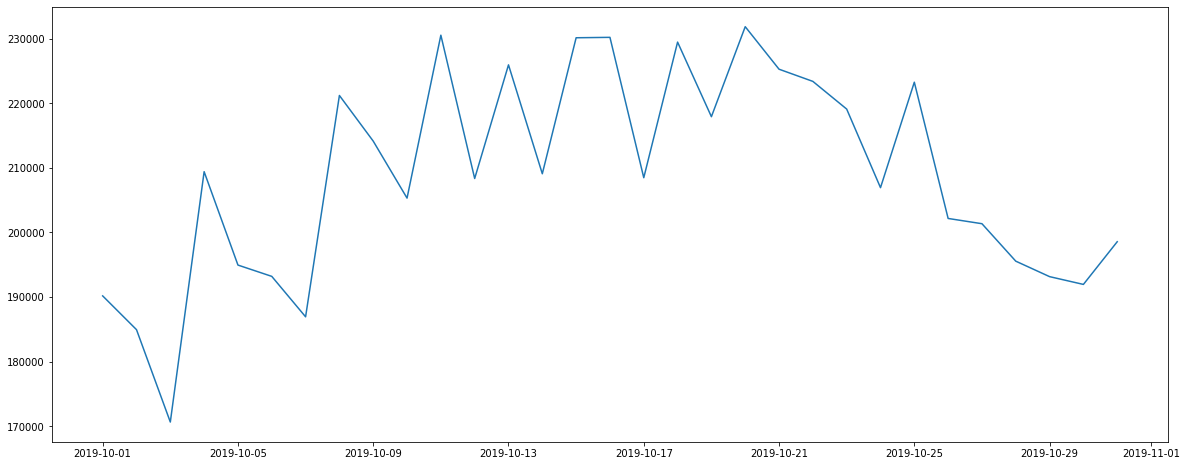

In [34]:
#fluctuation of customer traffic within october
d = df.loc[:,['event_time','user_id']]
d['event_time'] = d['event_time'].apply(lambda s: str(s)[0:10])
visitor_by_date = d.drop_duplicates().groupby(['event_time'])['user_id'].agg(['count']).sort_values(by=['event_time'], ascending=True)
x = pd.Series(visitor_by_date.index.values).apply(lambda s: datetime.strptime(s, '%Y-%m-%d').date())
y = visitor_by_date['count']
plt.rcParams['figure.figsize'] = (20,8)
plt.plot(x,y)
plt.show()

 So it can be easily observed that customer traffic increased from 10 october and remained consistent till 25th. After that it began to reduce.
# New Section

In [35]:
plt.savefig('oct.jpg')

<Figure size 1440x576 with 0 Axes>

In [36]:
#items bought by customers
purchased_items = df.loc[df['event_type'] == 'purchase']
purchased_items = purchased_items.dropna(axis='rows')
purchased_items.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
162,2019-10-01 00:02:14 UTC,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564
308,2019-10-01 00:04:37 UTC,purchase,1002532,2053013555631882655,electronics.smartphone,apple,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68
442,2019-10-01 00:07:07 UTC,purchase,13800054,2053013557418656265,furniture.bathroom.toilet,santeri,54.42,555332717,1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f
574,2019-10-01 00:09:26 UTC,purchase,4804055,2053013554658804075,electronics.audio.headphone,apple,189.91,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553
603,2019-10-01 00:09:54 UTC,purchase,4804056,2053013554658804075,electronics.audio.headphone,apple,161.98,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68


In [37]:
#count of sold categorycodes
sold_category = purchased_items.groupby('category_code')['category_code'].agg(['count']).sort_values(by='count',ascending=False)
sold_category.head(20)

,count
category_code,
electronics.smartphone,337575
electronics.audio.headphone,30439
electronics.video.tv,21548
electronics.clocks,16647
appliances.kitchen.washer,16059
computers.notebook,15547
appliances.environment.vacuum,12218
appliances.kitchen.refrigerators,8871
electronics.tablet,5599


In [38]:
#count of brands sold
sold_brands = purchased_items.groupby('brand')['brand'].agg(['count']).sort_values(by='count',ascending=False)
sold_brands.head(20)

,count
brand,
samsung,171706
apple,142577
xiaomi,46595
huawei,23294
oppo,10891
lg,7831
acer,6882
elenberg,5435
indesit,5023


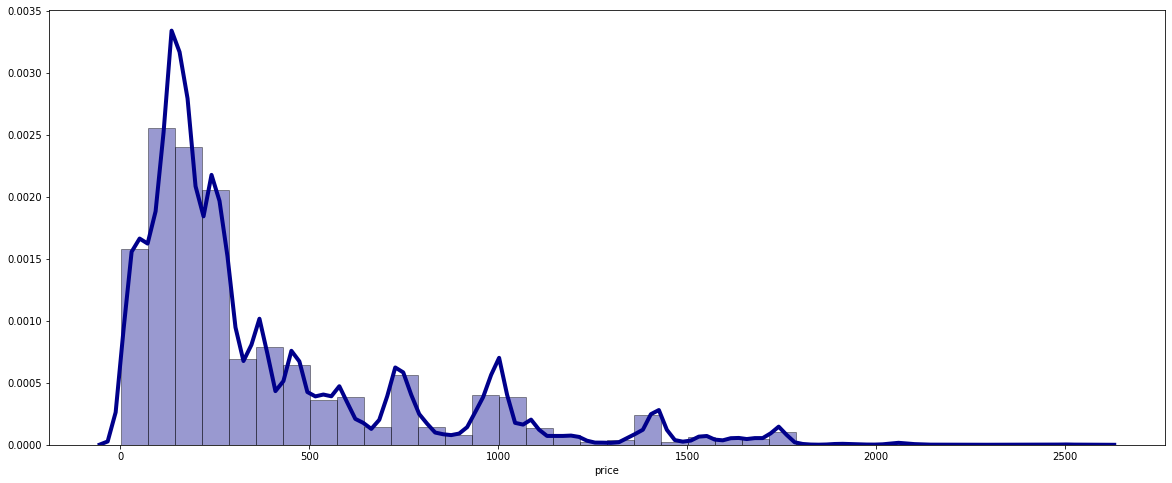

In [39]:
#distribution of prices
import seaborn as sns
sns.distplot(purchased_items['price'], hist=True, kde=True, 
bins=int(36), color = 'darkblue', 
hist_kws={'edgecolor':'black'},
kde_kws={'linewidth': 4})
plt.show()


In [0]:
#creating important columns and a predictive column:- is_purchased
df_targets = df.loc[df["event_type"].isin(["cart","purchase"])].drop_duplicates(subset=['event_type', 'product_id','price', 'user_id','user_session'])
df_targets["is_purchased"] = np.where(df_targets["event_type"]=="purchase",1,0)
df_targets["is_purchased"] = df_targets.groupby(["user_session","product_id"])["is_purchased"].transform("max")
df_targets = df_targets.loc[df_targets["event_type"]=="cart"].drop_duplicates(["user_session","product_id","is_purchased"])
df_targets['event_weekday'] = df_targets['event_time'].apply(lambda s: str(datetime.strptime(str(s)[0:10], "%Y-%m-%d").weekday()))
df_targets.dropna(how='any', inplace=True)
df_targets["category_code_main"] = df_targets["category_code"].str.split(".",expand=True)[0].astype('category')
df_targets["category_code_sub"] = df_targets["category_code"].str.split(".",expand=True)[1].astype('category')
cart_purchase_users = df.loc[df["event_type"].isin(["cart","purchase"])].drop_duplicates(subset=['user_id'])
cart_purchase_users.dropna(how='any', inplace=True)
cart_purchase_users_all = df.loc[df['user_id'].isin(cart_purchase_users['user_id'])]


In [41]:
#all users having event types as cart and purchased
activity_session = cart_purchase_users_all.groupby(['user_session'])['event_type'].count().reset_index()
activity_session = activity_session.rename(columns={"event_type": "activity_count"})
df_targets = df_targets.merge(activity_session, on='user_session', how='left')
df_targets['activity_count'] = df_targets['activity_count'].fillna(0)
df_targets.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,is_purchased,event_weekday,category_code_main,category_code_sub,activity_count
0,2019-10-01 00:09:33 UTC,cart,1002524,2053013555631882655,electronics.smartphone,apple,515.67,524325294,0b74a829-f9d7-4654-b5b0-35bc9822c238,1.0,1,electronics,smartphone,4.0
1,2019-10-01 00:11:00 UTC,cart,4804056,2053013554658804075,electronics.audio.headphone,apple,161.98,533624186,e5ac3caa-e6d5-4d6b-ae06-2c18cd9ca683,0.0,1,electronics,audio,4.0
2,2019-10-01 02:17:59 UTC,cart,1004833,2053013555631882655,electronics.smartphone,samsung,174.76,536415846,685b5b42-f597-4a69-ab4c-ef96a30bc454,0.0,1,electronics,smartphone,7.0
3,2019-10-01 02:19:36 UTC,cart,1005003,2053013555631882655,electronics.smartphone,huawei,258.21,513632293,f2cc68f7-39d1-4a50-9dcf-f2a0921bdfda,1.0,1,electronics,smartphone,16.0
4,2019-10-01 02:19:43 UTC,cart,1004750,2053013555631882655,electronics.smartphone,samsung,197.43,555110488,ce885079-4d92-4fe6-92a3-377c5a2d8291,1.0,1,electronics,smartphone,10.0


In [42]:
df_targets.columns

Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session',
       'is_purchased', 'event_weekday', 'category_code_main',
       'category_code_sub', 'activity_count'],
      dtype='object')

In [43]:
df_targets.isnull().sum()

event_time            0
event_type            0
product_id            0
category_id           0
category_code         0
brand                 0
price                 0
user_id               0
user_session          0
is_purchased          0
event_weekday         0
category_code_main    0
category_code_sub     0
activity_count        0
dtype: int64

In [44]:
df_targets.dtypes

event_time              object
event_type              object
product_id               int64
category_id              int64
category_code           object
brand                   object
price                  float64
user_id                  int64
user_session            object
is_purchased           float64
event_weekday           object
category_code_main    category
category_code_sub     category
activity_count         float64
dtype: object

In [45]:
df_targets['event_weekday'].value_counts()

4    83694
1    82084
2    79998
3    77707
6    76854
5    76820
0    69442
Name: event_weekday, dtype: int64

In [46]:
df_targets['category_code_main'].value_counts()[:10]

electronics     451826
appliances       62132
computers        19481
auto              5080
construction      3992
kids              1651
furniture          989
sport              584
accessories        394
medicine           354
Name: category_code_main, dtype: int64

In [47]:
df_targets['category_code_sub'].value_counts()[:10]

smartphone     367434
kitchen         39978
audio           35065
video           24772
environment     15852
clocks          14335
notebook        11167
tablet           6116
accessories      5080
tools            4312
Name: category_code_sub, dtype: int64

In [48]:
df_targets['category_id'].value_counts()[:10]

2053013555631882655    367434
2053013554658804075     34129
2053013554415534427     24609
2053013563810775923     14607
2053013553341792533     14297
2053013565983425517     11692
2053013558920217191     11144
2053013563911439225      6776
2172371436436455782      5868
2053013554776244595      3340
Name: category_id, dtype: int64

In [49]:
df_targets['brand'].value_counts()[:10]

samsung     198185
apple       146486
xiaomi       53147
huawei       27525
oppo         13470
lg            8429
acer          6719
elenberg      5451
indesit       4607
haier         4036
Name: brand, dtype: int64

In [0]:
#binning of mobile phones
a=['samsung','oppo','lg','huawei','xiaomi','apple']
indicator=[]   
for i in df_targets['brand']: 
    if i in a:
        indicator.append(i)
    else: 
        indicator.append('all other phone')
df_targets.insert(len(df_targets.columns),"MOB_BRAND",indicator,False) 

In [51]:
df_targets['category_code'].value_counts()[:10]

electronics.smartphone              367434
electronics.audio.headphone          34129
electronics.video.tv                 24673
appliances.kitchen.washer            14607
electronics.clocks                   14335
appliances.environment.vacuum        11743
computers.notebook                   11167
appliances.kitchen.refrigerators      8433
electronics.tablet                    6116
electronics.telephone                 3706
Name: category_code, dtype: int64

In [0]:
#binning of category_codes
a=['electronics.smartphone','electronics.audio.headphone','electronics.video.tv','appliances.kitchen.washer','electronics.clocks','appliances.environment.vacuum','computers.notebook']
indicator=[]   
for i in df_targets['category_code']: 
    if i in a:
        indicator.append(i)
    else: 
        indicator.append('all other categories')
df_targets.insert(len(df_targets.columns),"cat_codes",indicator,False) 

In [53]:
df_targets.columns

Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session',
       'is_purchased', 'event_weekday', 'category_code_main',
       'category_code_sub', 'activity_count', 'MOB_BRAND', 'cat_codes'],
      dtype='object')

In [0]:
#creation of training dataset
df_train_targets=df_targets[['event_time', 'event_type', 'product_id', 'category_id',
       'price', 'user_id', 'user_session',
       'is_purchased', 'event_weekday', 'category_code_main',
       'category_code_sub', 'activity_count', 'MOB_BRAND', 'cat_codes']].copy()
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
le_cols=['category_code_main','product_id', 'category_id','event_weekday','event_time', 'event_type','user_id', 'user_session',
       'category_code_sub']
#label encoding of above categorical columns       
for i in le_cols:
  df_train_targets[i]=le.fit_transform(df_train_targets[i])
 #creating dummies of mobile brand and categorical codes 
cat_cols=['MOB_BRAND', 'cat_codes']
df_train_targets=pd.get_dummies(data=df_train_targets,columns=cat_cols) 


In [55]:
df_train_targets.dtypes

event_time                                   int64
event_type                                   int64
product_id                                   int64
category_id                                  int64
price                                      float64
user_id                                      int64
user_session                                 int64
is_purchased                               float64
event_weekday                                int64
category_code_main                           int64
category_code_sub                            int64
activity_count                             float64
MOB_BRAND_all other phone                    uint8
MOB_BRAND_apple                              uint8
MOB_BRAND_huawei                             uint8
MOB_BRAND_lg                                 uint8
MOB_BRAND_oppo                               uint8
MOB_BRAND_samsung                            uint8
MOB_BRAND_xiaomi                             uint8
cat_codes_all other categories 

In [0]:
#importing libraries for model valuation and algorithms
from sklearn import preprocessing
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import LogisticRegression
#from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from IPython.display import display
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [0]:
#function for model evaluated parameters
def model_eval(test_tar,pred):  
    TN, FP, FN, TP = confusion_matrix(test_tar,pred).ravel()
    accuracy = metrics.accuracy_score(test_tar,pred)
    precision = metrics.precision_score(test_tar,pred)
    recall = metrics.recall_score(test_tar,pred)
    f_measure = (2*recall*precision)/(recall+precision)
    auc=roc_auc_score (test_tar,pred)
    specificity=(TN)/(TN+FP)
    FPR=1-specificity
    out = {}
    out['True Positive']=TP
    out['True Negative']=TN
    out['False Positive']=FP
    out['False Negative']=FN
    out['FPR']=FPR
    out['accuracy'] =  accuracy
    out['precision'] = precision
    out['recall'] = recall
    out['f_measure'] = f_measure 
    out['auc_score']=round(auc,2)
#     print("dekho",fpr1)
    return out

In [58]:
df_train_targets['is_purchased'].value_counts()

1.0    273908
0.0    272691
Name: is_purchased, dtype: int64

In [0]:
# defining dependent and independent variables 
x=df_train_targets.drop(['is_purchased'],axis=1)
y=df_train_targets['is_purchased']
#train, test and dev split
train_features, test_features, train_tar, test_tar = train_test_split(x, y, test_size = 0.2, random_state = 100)
#taking test and deviation sets to be from a same distribution for hyperparameter tuning
test_features,train_dev,test_tar,test_dev= train_test_split(test_features, test_tar, test_size = 0.5, random_state = 100)

## **Ensemble Learning**

**Ensemble learning** is a machine learning paradigm where multiple models often called weak learners are trained to solve the same problem and combined to get better results. The main hypothesis is that when weak models are correctly combined we can obtain more robust models.So here several base models are combined to form an optimal model.

**Weak Learners**:- The smaller building blocks for designing better and complex models since these algorithms either have a huge bias(underfitting) or a very high variance(overfitting).

**Strong learners**:-Its a combination of several weak learners which has the ability to acheive better performances.The base learners may be homogeneous(i.e- just one basic algorithm like decision trees) or heterogeneous(i.e:- a combination of several base algorithms).

The successive models chosen in ensemble learning techniques must be such that they tend to diminish the issues(high bias or variance) caused by the previous models and improve performance.For ex:- **the** **decision tree** **bagging ensemble achieves higher accuracy** **in comparison to the** **k-NN** **bagging ensemble**. K-NN are less sensitive to perturbation on training samples and therefore they are called **stable learners**.The stable learners won't improve generalization performance.

The types of ensemble learning techniques is basically about the ways the base algorithms or weak learners are combined to improve performance.Predomintely there are three kinds of such combinations:-


**1) Bagging Algorithms**
**2) Boosting Algorithms**
**3)Stacking Algorithms** 

Bagging and Boosting Algorithms will be discussed here.

## **Bagging Algorithms**



These algorithms often consider homogeneous weak learners, learns them independently from each other in parallel to get a generalized result.It is also termed as **bootstrap aggregating**.It is generally focussed on getting an ensemble model with smaller variance than the weak learners.
Bagging uses bootstrap sampling to obtain the data subsets for training the base learners. For aggregating the outputs of base learners, bagging uses voting for classification and averaging for regression.Bootstrap sampling seemingly appearing as a complicated terminology is nothing other than a random replacement leading to independent and identically distributed samples. The idea of bagging is then simple: we want to fit several independent models and average their predictions in order to obtain a model with a lower variance.

**So bagging algorithms create multiple bootstrap samples and each bootstrap sample acts as a dataset on which the weak learners are trained and fitted.They are then aggregated or in other words their outputs are averaged(in regression) and maximum votes are taken(in classification). Since the samples were iid and were true representations of original dataset, we obtain a lower variance than those of the weak learners.**




## **Random Forests**


Random Forest is an ensemble machine learning algorithm that follows the bagging technique. It is an extension of the bagging estimator algorithm. The base estimators in random forest are decision trees. **Random forest randomly selects a set of features which are used to decide the best split at each node of the decision tree.**
So in very simple words, the bagging algorithms only subset over the number of observations in general but random forests also sample over the number of feeatures that can be kept since certain features may be more important than the others.
**Another advantage of sampling over the features is that it makes the decision making process more robust to missing data.** This is understandable as certain features may have a large number of missing values and others may have very few or no missing values which can be taken into account.Random Forests are more effective in reduction of variance with a slight increment in bias than other bagging algorithms.


### Important Parameters in Random Forest Algorithms

1) **n_estimators**(default=100):- The number of trees in the forest.

2)**criterion(default=”gini”)**:- The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.


**3) max_depth(default=None)**:-The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.


**4) min_samples_split(default=2)**:- The minimum number of samples required to split an internal node:


**5) max_features(default='auto')**:-The number of features to consider when looking for the best split.














If “auto”, then max_features=sqrt(n_features).

If “sqrt”, then max_features=sqrt(n_features) (same as “auto”).



**6) max_leaf_nodes(default=None)**:-Grow trees with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.



**7) bootstrap(default=True)**:-Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.


**8) n_jobs(default=None)**:-The number of jobs to run in parallel. 
:-The number of jobs to run in parallel. 


### **Now we are gonna use Random Forests as a classification algorithm**

Classifier Runtime: 229.34781765937805s
Prediction Runtime: 1.8768038749694824s
FOR TEST SET


,True Positive,True Negative,False Positive,False Negative,FPR,accuracy,precision,recall,f_measure,auc_score
80-20 split,19283,14226,13198,7953,0.48,0.61,0.59,0.71,0.65,0.61


FOR TRAIN SET


,True Positive,True Negative,False Positive,False Negative,FPR,accuracy,precision,recall,f_measure,auc_score
80-20 split,164049,118884,99031,55315,0.45,0.65,0.62,0.75,0.68,0.65


FOR WHOLE SET


,True Positive,True Negative,False Positive,False Negative,FPR,accuracy,precision,recall,f_measure,auc_score
80-20 split,202750,147310,125381,71158,0.46,0.64,0.62,0.74,0.67,0.64


No handles with labels found to put in legend.


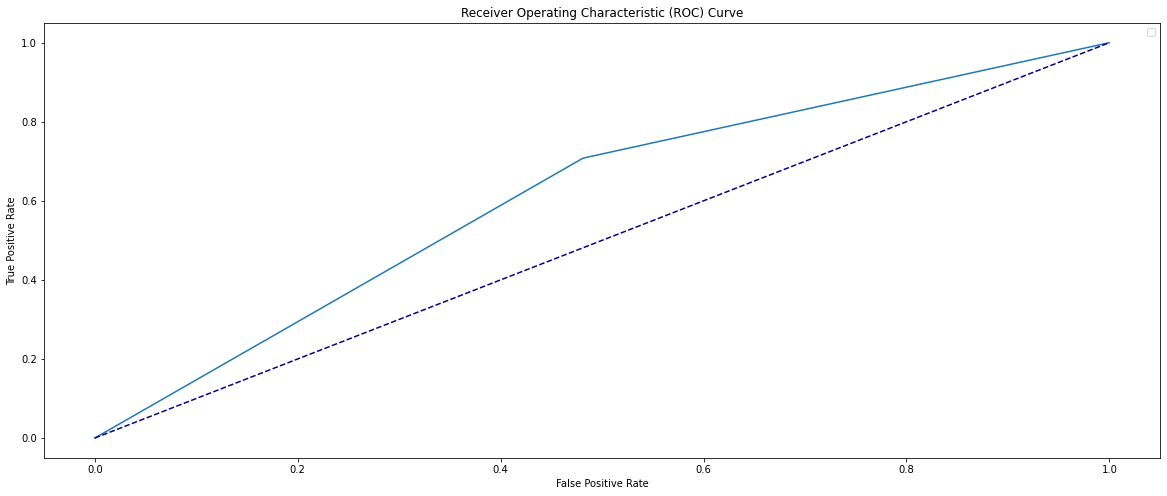

In [60]:
#Random Forests
import time
rf = RandomForestClassifier(n_estimators=200,min_samples_split=5,min_samples_leaf=4,max_features= 'auto',max_depth=13,bootstrap=False)
t0=time.time()
clf_gini = rf.fit(train_features,train_tar)
t1=time.time()
clf_gini_pred_test = clf_gini.predict(test_features)
t2=time.time()
clf_gini_pred_train = clf_gini.predict(train_features)
clf_gini_pred_whole = clf_gini.predict(x)
d1,d2,d3=[],[],[]
w1=model_eval(test_tar,clf_gini_pred_test)
d1.append(w1)
w2=model_eval(train_tar,clf_gini_pred_train)
d2.append(w2)
w3=model_eval(y,clf_gini_pred_whole)
d3.append(w3)
print('Classifier Runtime: '+ str(t1-t0)+'s')
print('Prediction Runtime: '+ str(t2-t1)+'s')
print("FOR TEST SET")
Class_Algo_dt1= round(pd.DataFrame(d1,index=['80-20 split']),2)
display(Class_Algo_dt1)
print("FOR TRAIN SET")
Class_Algo_dt2= round(pd.DataFrame(d2,index=['80-20 split']),2)
display(Class_Algo_dt2)
print("FOR WHOLE SET")
Class_Algo_dt3= round(pd.DataFrame(d3,index=['80-20 split']),2)
display(Class_Algo_dt3)
fpr, tpr, thresholds = roc_curve(test_tar, clf_gini_pred_test)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


In [61]:
#hyperparameter tuning
from scipy.stats import randint 
from sklearn.model_selection import RandomizedSearchCV 
  
# Creating the hyperparameter grid  
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [200]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5,50)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
# Instantiating Decision Tree classifier 
tree = RandomForestClassifier() 
# Instantiating RandomizedSearchCV object 
tree_cv = RandomizedSearchCV(estimator=tree,n_iter=10,param_distributions=random_grid, cv =4,scoring='accuracy',n_jobs=-1,verbose=2) 
tree_cv.fit(train_dev,test_dev) 
  
# Print the tuned parameters and score 
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_)) 
print("Best score is {}".format(tree_cv.best_score_)) 


Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 11.1min finished


Tuned Decision Tree Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 16, 'bootstrap': False}
Best score is 0.6021953896816684


Classifier Runtime: 146.84893155097961s
Prediction Runtime: 2.5031867027282715s
FOR TEST SET


,True Positive,True Negative,False Positive,False Negative,FPR,accuracy,precision,recall,f_measure,auc_score
80-20 split,19468,13816,13608,7768,0.5,0.61,0.59,0.71,0.65,0.61


FOR TRAIN SET


,True Positive,True Negative,False Positive,False Negative,FPR,accuracy,precision,recall,f_measure,auc_score
80-20 split,157729,108930,108985,61635,0.5,0.61,0.59,0.72,0.65,0.61


FOR WHOLE SET


,True Positive,True Negative,False Positive,False Negative,FPR,accuracy,precision,recall,f_measure,auc_score
80-20 split,196851,136461,136230,77057,0.5,0.61,0.59,0.72,0.65,0.61


No handles with labels found to put in legend.


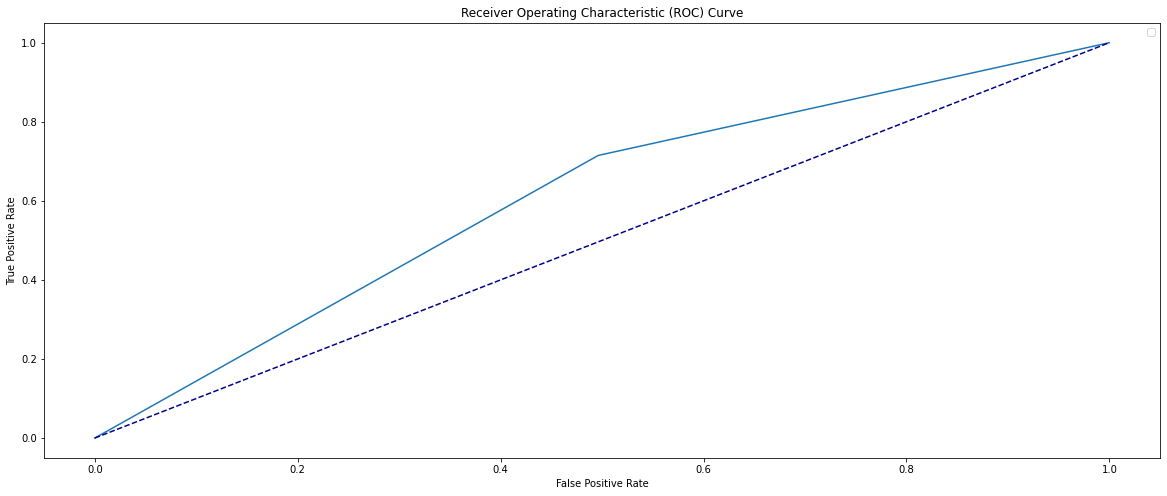

In [62]:
#Adaptive Boosting
from sklearn.ensemble import AdaBoostClassifier
import time
adb = AdaBoostClassifier(n_estimators=200,learning_rate=0.3)
t0=time.time()
clf_gini = adb.fit(train_features,train_tar)
t1=time.time()
clf_gini_pred_test = clf_gini.predict(test_features)
t2=time.time()
clf_gini_pred_train = clf_gini.predict(train_features)
clf_gini_pred_whole = clf_gini.predict(x)
d1,d2,d3=[],[],[]
w1=model_eval(test_tar,clf_gini_pred_test)
d1.append(w1)
w2=model_eval(train_tar,clf_gini_pred_train)
d2.append(w2)
w3=model_eval(y,clf_gini_pred_whole)
d3.append(w3)
print('Classifier Runtime: '+ str(t1-t0)+'s')
print('Prediction Runtime: '+ str(t2-t1)+'s')
print("FOR TEST SET")
Class_Algo_dt1= round(pd.DataFrame(d1,index=['80-20 split']),2)
display(Class_Algo_dt1)
print("FOR TRAIN SET")
Class_Algo_dt2= round(pd.DataFrame(d2,index=['80-20 split']),2)
display(Class_Algo_dt2)
print("FOR WHOLE SET")
Class_Algo_dt3= round(pd.DataFrame(d3,index=['80-20 split']),2)
display(Class_Algo_dt3)
fpr, tpr, thresholds = roc_curve(test_tar, clf_gini_pred_test)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


In [0]:
#xgboost ka use
def modelfit(alg,dtrain,predictors,train_y,dtest,test_y,useTrainCV=False, cv_folds=5,early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=train_y.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], train_y,eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Predict test set:
    dtest_predictions = alg.predict(dtest[predictors])
    dtest_predprob = alg.predict_proba(dtest[predictors])[:,1]
    
        
    #Print model report:
    print ("\nModel Report")
#     print ("Accuracy : %.4g" % metrics.accuracy_score(test_y.values, dtest_predictions))
#     print ("AUC Score (Train): %f" % metrics.roc_auc_score(train_y, dtrain_predprob))
    a1,a2=[],[] 
#evaluations on test set
    w1=model_eval(test_tar, dtest_predictions)
    a1.append(w1)
#evaluations on train set
    w2=model_eval(train_tar,dtrain_predictions)
    a2.append(w2)
#print(w)
    print("FOR TEST SET")
    Class_Algo1= round(pd.DataFrame(a1,index=['80-20 split']),2)
    display(Class_Algo1)
    print("FOR TRAIN SET")
    Class_Algo2= round(pd.DataFrame(a2,index=['80-20 split']),2)
    display(Class_Algo2)
    fpr, tpr, thresholds = roc_curve(test_tar, dtest_predictions)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show() 
                    




Model Report
FOR TEST SET


,True Positive,True Negative,False Positive,False Negative,FPR,accuracy,precision,recall,f_measure,auc_score
80-20 split,38471,29176,25600,16073,0.47,0.62,0.6,0.71,0.65,0.62


FOR TRAIN SET


,True Positive,True Negative,False Positive,False Negative,FPR,accuracy,precision,recall,f_measure,auc_score
80-20 split,155724,116450,101465,63640,0.47,0.62,0.61,0.71,0.65,0.62


No handles with labels found to put in legend.


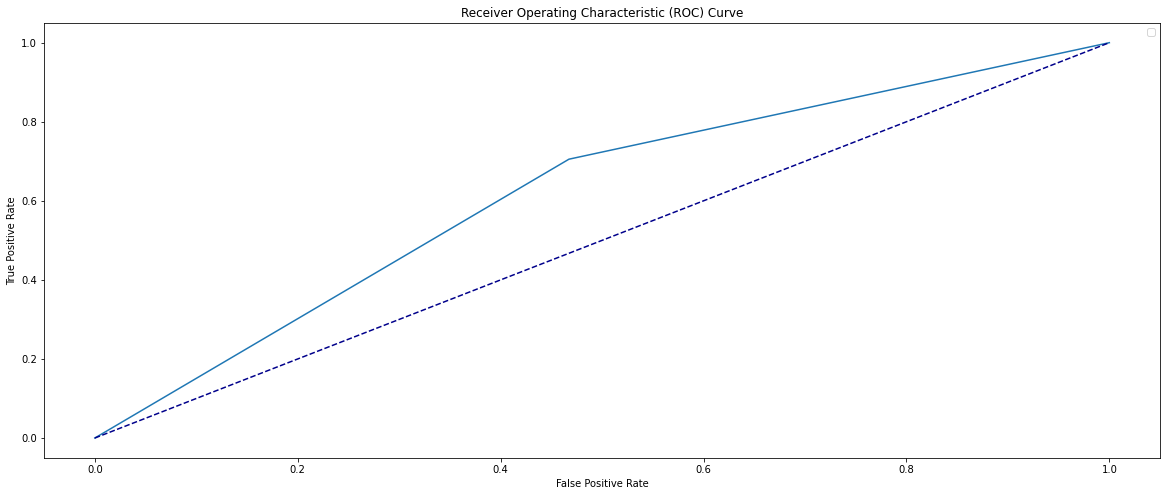

In [64]:

train_features, test_features, train_tar, test_tar = train_test_split(x,y, test_size = 0.2, random_state = 100)
predictors=train_features.columns
xgb1 = XGBClassifier(n_estimators=200, objective='binary:logistic',nthread=1,colsample_bytree=0.7465358812035496,gamma=0.2,learning_rate=0.2,max_depth=3,min_child_weight=1.113725423172304,subsample=0.9867245659081166)
modelfit(xgb1, train_features,predictors,train_tar,test_features,test_tar)


In [65]:
#hyperparameter tuning
from scipy.stats import uniform  
from sklearn.model_selection import RandomizedSearchCV 
# Creating the hyperparameter grid  
# param_dist = {"max_depth": uniform(4, 15), 
#                "n_estimators": [100],
#               "colsample_bylevel": uniform(1,3)
#               "objective":['binary:logistic'],
#               "learning_rate": uniform(0.1,0.3),
#               "max_features": uniform(1,79), 
#               "min_samples_leaf": uniform(1, 15), 
#                "silent":[True,False],
#                "reg_alpha": [0,1],
#                 "reg_lambda": [0,1]} 
param_dist = {
        'min_child_weight': uniform(1,2),
        'gamma': [i/10 for i in range(1,5)],
        'subsample': uniform(0.1,1),
        'colsample_bytree': uniform(0.5,1),
        'max_depth': [3, 4, 5,7,9,11],
        'learning_rate': [i/10 for i in range(1,5)]
        }
# Instantiating Decision Tree classifier 
xgb1 = XGBClassifier(n_estimators=200, objective='binary:logistic',nthread=1)
# Instantiating RandomizedSearchCV object 
tree_cv = RandomizedSearchCV(xgb1, param_distributions=param_dist, n_iter=25, scoring='roc_auc', n_jobs=-1, cv=4, verbose=3, random_state=100) 
tree_cv.fit(test_features,test_tar) 
  
# Print the tuned parameters and score 
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_)) 
print("Best score is {}".format(tree_cv.best_score_)) 

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 18.5min finished


Tuned Decision Tree Parameters: {'colsample_bytree': 0.7465358812035496, 'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 1.113725423172304, 'subsample': 0.9867245659081166}
Best score is 0.6658578104899603


In [66]:
#train,test rmse mean and std
data_dmatrix = xgb.DMatrix(data=train_features,label=train_tar)
params = {"objective":"reg:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix , params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)
print(cv_results.head())

#importance graphs
xgb.plot_importance(xgb1)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()


   train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0         0.496200        0.000054        0.496267       0.000015
1         0.493904        0.001262        0.493965       0.001244
2         0.492616        0.001913        0.492652       0.001947
3         0.492108        0.001978        0.492147       0.001974
4         0.490822        0.002308        0.490913       0.002245


XGBoostError: ignored

In [0]:
from xgboost import plot_importance
plot_importance(xgb1, max_num_features=10, importance_type ='gain')
plt.rcParams['figure.figsize'] = (40,10)
plt.show()
